In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import os
import random
import tensorflow as tf
import math
import pandas as pd

# Set seeds for reproducibility
seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Parameters
M = 2 # 30
nx = 401
nt = 301
x_max = 1.0
t_max = 1.0
x = np.linspace(0, x_max, nx)
t = np.linspace(0, t_max, nt)

In [ ]:
# Set seeds for reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Fractional flow function and its derivative
def f_w(u):
    return (u**2) / (u**2 + ((1 - u)**2) / M)

def df_w(u):
    den = M*u**2 + (1 - u)**2
    return 2 * M * u * (1 - u) / den**2

# Solve for shock saturation u* (u_star, Saturation value at shock)
def shock_condition(u):
    return df_w(u) - f_w(u)/u

init_guess = 0.5 # Change this if you change M. (for M = 30, make it 0.2)

u_star = fsolve(shock_condition, init_guess)[0]
# Or u_star = np.sqrt(1/(1+M)) #(Analytical for Non Convex)
s = f_w(u_star) / u_star  # Shock speed

print(f'u_star: {u_star}')
print(f'Shock speed s: {s}')



u_star: 0.5773502691896258
Shock speed s: 1.3660254037844388


In [ ]:
# Set seeds for reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

from functools import lru_cache

@lru_cache(maxsize=5000)
def cached_root(e):
    def root_eq(u):
        return df_w(u) - e
    x = fsolve(root_eq, init_guess)[0]
    return x

# Analytical Buckley-Leverett solution

def u_analytic(x, t):
    if t == 0:
        return 0.0
    if x == 0:
        return 1.0

    x_shock = s * t
    u_star = np.sqrt(1 / (1 + M))

    if x > x_shock:
        return 0.0
    elif abs(x - x_shock) < 1e-6:
        return u_star
    else:
        e = x / t
        return cached_root(e)


In [ ]:
# Set seeds for reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Evaluate u(x) for each desired time
u_results = {}
shock_locations = {}

for t_eval in t:
    u_t = np.array([u_analytic(xi, t_eval) for xi in x])
    u_results[t_eval] = u_t
    shock_locations[t_eval] = s * t_eval


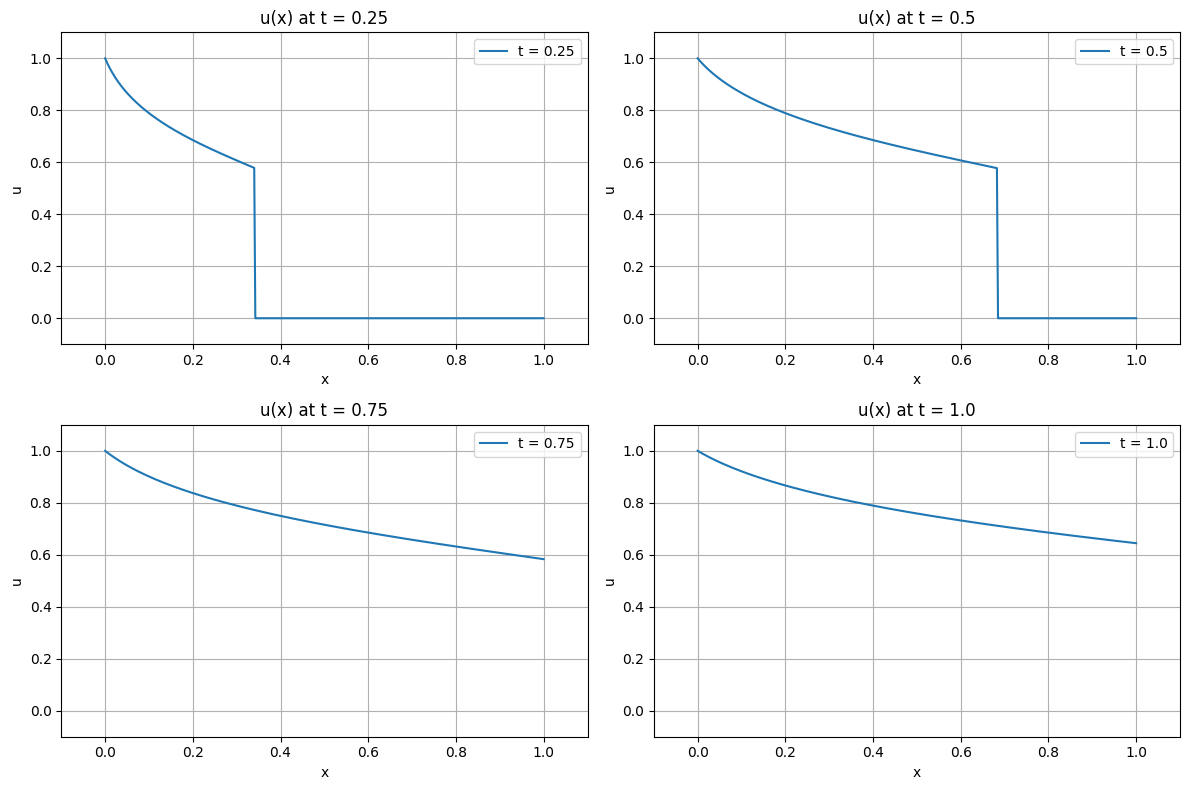

In [ ]:
# Plotting

t_values = [0.25, 0.5, 0.75, 1.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, t_eval in enumerate(t_values):
    ax = axes[i]
    ax.plot(x, u_results[t_eval], label=f't = {t_eval}')
    shock_x = shock_locations[t_eval]

    ax.set_title(f'u(x) at t = {t_eval}')
    ax.set_xlabel('x')
    ax.set_ylabel('u')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


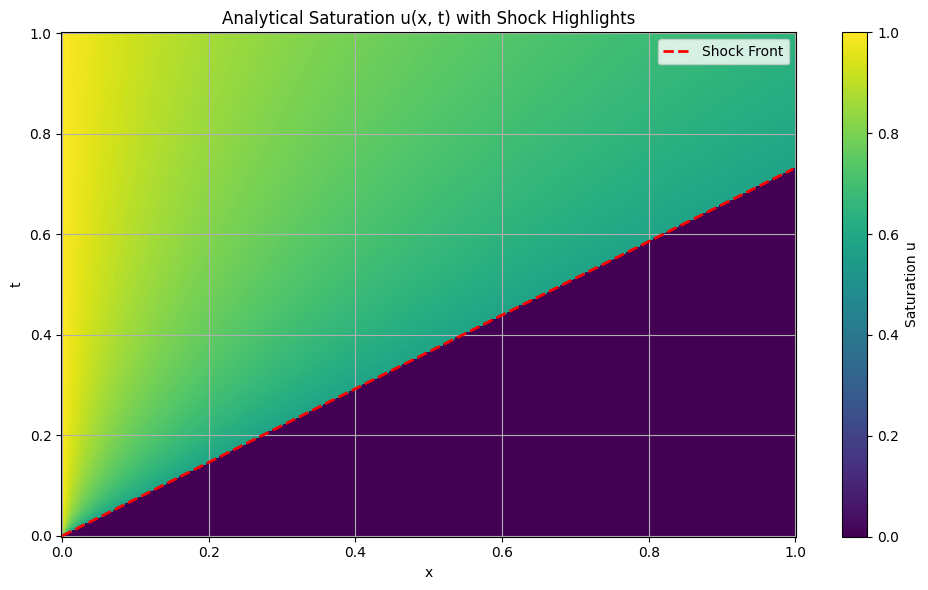

In [ ]:
# 2D for plotting

U = np.array([u_results[ti] for ti in t])  # shape: (nt, nx)

plt.figure(figsize=(10, 6))

X, T = np.meshgrid(x, t)

c = plt.pcolormesh(X, T, U, shading='auto', cmap='viridis')
plt.colorbar(c, label='Saturation u')

# --- Shock front (x = s * t) ---
x_shock = s * t
mask = x_shock <= x_max   # only keep points within domain
plt.plot(x_shock[mask], t[mask], color='red', linestyle='--', linewidth=2.0, label='Shock Front')


plt.xlabel('x')
plt.ylabel('t')
plt.title('Analytical Saturation u(x, t) with Shock Highlights')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Data Preparation for XPINN

In [ ]:
# Set seeds for reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Generate XPINN training data

# Parameters
n_init = 200
n_bc = 200
n_before = 2000
n_after = 2000
n_shock = 200
eps = 1e-6  # buffer to separate regions


collocation_before_shock = []
while len(collocation_before_shock) < n_before:
    ti = np.random.uniform(1e-4, t_max)
    x_shock = s * ti
    xi = np.random.uniform(0, x_max)
    if xi < x_shock - eps:
        collocation_before_shock.append([xi, ti])
collocation_before_shock = np.array(collocation_before_shock)

collocation_after_shock = []
while len(collocation_after_shock) < n_after:
    ti = np.random.uniform(1e-4, t_max)
    x_shock = s * ti
    xi = np.random.uniform(0, x_max)
    if xi > x_shock + eps:
        collocation_after_shock.append([xi, ti])
collocation_after_shock = np.array(collocation_after_shock)

t_shock = t
x_shock = s * t_shock
collocation_on_shock = np.column_stack([x_shock, t_shock])

# Initial and boundary conditions
x_init = np.linspace(0, x_max, n_init)[:, None]
t_init = np.zeros_like(x_init)
data_initial = np.hstack([x_init, t_init])

x_bc_0 = np.zeros((n_bc, 1))
t_bc_0 = np.linspace(1e-8, t_max, n_bc)[:, None]
data_bc_0 = np.hstack([x_bc_0, t_bc_0])

# Organize XPINN data
data = {
    "before_shock": collocation_before_shock,
    "on_shock": collocation_on_shock,
    "after_shock": collocation_after_shock,
    "initial": data_initial,
    "data_bc_0": data_bc_0
}


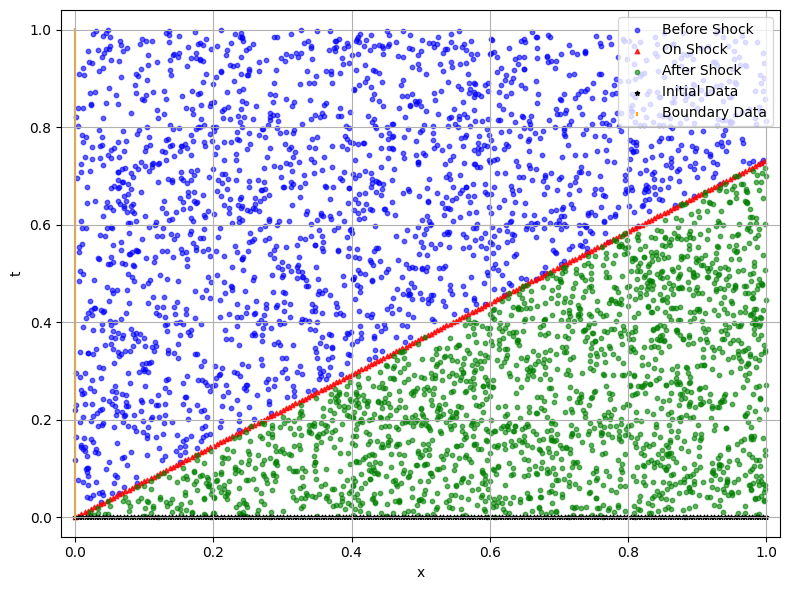

In [ ]:
# Training Data Distribution Plot

plt.figure(figsize=(8, 6))

# Collocation/data points
plt.scatter(*data["before_shock"].T, s=10, color='blue', label='Before Shock', alpha=0.6)
plt.scatter(*data["on_shock"][data["on_shock"][:,0] <= x_max].T, s=10, color='red', label='On Shock', alpha=0.8, marker='^')
plt.scatter(*data["after_shock"].T, s=10, color='green', label='After Shock', alpha=0.6)
plt.scatter(*data["initial"].T, s=10, color='black', label='Initial Data', marker='*')
plt.scatter(*data["data_bc_0"].T, s=10, color='orange', label='Boundary Data', marker='|')


plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.grid(True)
plt.xlim([-0.02, x_max + 0.02])
plt.ylim([-0.04, t_max + 0.04])
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


ε is 0.007


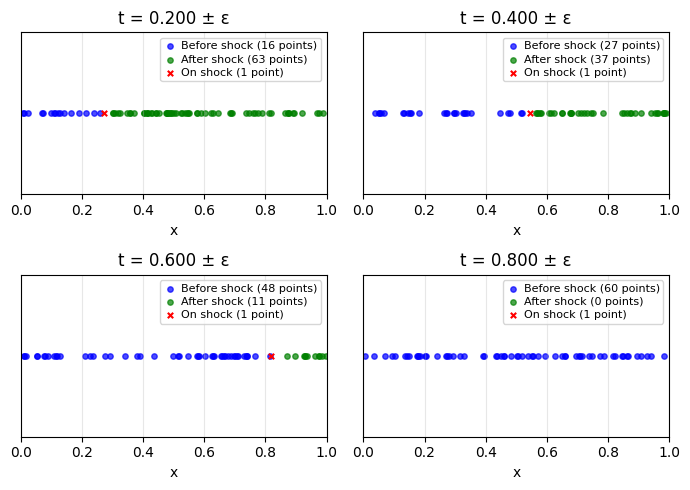

In [ ]:
# Dynamic Domain Decomposition in Space and Time

import math

selected_times = [0.2, 0.4, 0.6, 0.8]
ncols = 2
time_window = 0.015  # ±0.015 around each selected time
print(f"ε is {(time_window/2):.3f}")

n_plots = len(selected_times)
nrows = math.ceil(n_plots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(3.5 * ncols, 2.5 * nrows))
axes = np.array(axes).reshape(-1)

for i, t_selected in enumerate(selected_times):
    ax = axes[i]

    # Time window masks
    before_mask = ((collocation_before_shock[:, 1] >= t_selected - time_window / 2) & (collocation_before_shock[:, 1] <= t_selected + time_window / 2))
    after_mask = ((collocation_after_shock[:, 1] >= t_selected - time_window / 2) & (collocation_after_shock[:, 1] <= t_selected + time_window / 2))
    on_mask = np.abs(collocation_on_shock[:, 1] - t_selected) < 1e-10

    # Point counts
    n_before = np.sum(before_mask)
    n_on = np.sum(on_mask)
    n_after = np.sum(after_mask)

    # Scatter each set (y=0 line)
    ax.scatter(collocation_before_shock[before_mask, 0],np.zeros_like(collocation_before_shock[before_mask, 0]),s=15, alpha=0.7, color='blue',label=f"Before shock ({n_before} points)")
    ax.scatter(collocation_after_shock[after_mask, 0],np.zeros_like(collocation_after_shock[after_mask, 0]),s=15, alpha=0.7, color='green',label=f"After shock ({n_after} points)")
    ax.scatter(collocation_on_shock[on_mask, 0],np.zeros_like(collocation_on_shock[on_mask, 0]),s=15, color="red", marker='x',label=f"On shock ({n_on} point)")


    ax.set_xlabel("x")
    ax.set_title(f"t = {t_selected:.3f} ± ε")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, x_max)
    ax.set_ylim(-0.1, 0.1)
    ax.set_yticks([])
    ax.legend(loc='upper right', fontsize=9, frameon=True)

    # legend
    leg = ax.legend(
        loc='upper right',
        fontsize=8,
        frameon=True,
        handlelength=1.2,
        borderpad=0.3,
        labelspacing=0.3,
        handletextpad=0.4
    )
    leg._legend_box.align = "left"

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Set seeds for reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Prepare XPINN training data
colloc_before = data["before_shock"]  # subdomain 1
colloc_after = data["after_shock"]    # subdomain 2
colloc_on = data["on_shock"]          # interface only
data_init = data["initial"]
data_bc_0 = data["data_bc_0"]

# Boundary + initial conditions
X_ub_train = np.vstack([data_bc_0, data_init])
ub_train = np.vstack([
    np.ones_like(data_bc_0[:, 0:1]),
    np.zeros_like(data_init[:, 0:1])
])

# Tensor conversion
X_ub_train_tf  = tf.convert_to_tensor(X_ub_train, dtype=tf.float32)
ub_train_tf    = tf.convert_to_tensor(ub_train, dtype=tf.float32)

# Subdomain collocation points
X_f1_train_tf  = tf.convert_to_tensor(colloc_before, dtype=tf.float32)  # domain 1
X_f2_train_tf  = tf.convert_to_tensor(colloc_after,  dtype=tf.float32)  # domain 2

# Interface collocation points
X_fi1_train_tf = tf.convert_to_tensor(colloc_on, dtype=tf.float32)      # interface

# XPINN Model

In [ ]:
# Xavier initializer
def xavier_init(size):
    in_dim, out_dim = size
    std = np.sqrt(2.0 / (in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev=std), dtype=tf.float32)

# NN architecture
def initialize_NN(layers):
    weights, biases, A = [], [], []
    for l in range(len(layers) - 1):
        weights.append(xavier_init([layers[l], layers[l+1]]))
        biases.append(tf.Variable(tf.zeros([1, layers[l+1]], dtype=tf.float32)))
        A.append(tf.Variable(0.05, dtype=tf.float32))
    return weights, biases, A

def neural_net(X, weights, biases, A):
    H = X
    for l in range(len(weights) - 1):
        H = tf.tanh(20 * A[l] * (tf.matmul(H, weights[l]) + biases[l]))
    return tf.matmul(H, weights[-1]) + biases[-1]

# PDE + interface residuals for 2 subdomains
@tf.function
def residual_xpinn(x1, t1, x2, t2, xi1, ti1,
          W1, W2, b1, b2, A1, A2, jump = False):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x1, t1, x2, t2, xi1, ti1])

        # Predictions in subdomains
        u1 = neural_net(tf.concat([x1, t1], 1), W1, b1, A1)
        u2 = neural_net(tf.concat([x2, t2], 1), W2, b2, A2)

        # Interface values
        u1i1 = neural_net(tf.concat([xi1, ti1], 1), W1, b1, A1)
        u2i1 = neural_net(tf.concat([xi1, ti1], 1), W2, b2, A2)

        # Fluxes
        fw1 = f_w(u1)
        fw2 = f_w(u2)

    # Gradients (first derivatives)
    u1_t = tape.gradient(u1, t1)
    u2_t = tape.gradient(u2, t2)
    fw1_x = tape.gradient(fw1, x1)
    fw2_x = tape.gradient(fw2, x2)

    del tape  # to free memory

    # Residuals: u_t + d/dx(f(u))
    f1 = u1_t + fw1_x
    f2 = u2_t + fw2_x

    if jump:
        fwu1i1 = f_w(u1i1)
        fwu2i1 = f_w(u2i1)
        # Rankine–Hugoniot Jump Condition
        numerator = fwu2i1 - fwu1i1
        denominator = u2i1 - u1i1
        jump_condition = numerator / (denominator + 1e-8)
        jump_loss = tf.square(jump_condition - s)
    else:
        jump_loss = 0.0

    return f1, f2, jump_loss



In [ ]:
@tf.function
def train_xpinn(W1, b1, A1, W2, b2, A2, X_ub, ub, X_f1, X_f2, X_fi1, opt1, opt2, jump = False):

    # Initial and Boundary points
    x_ub, t_ub = X_ub[:, 0:1], X_ub[:, 1:2]

    # Collocation points in subdomains
    x_f1, t_f1 = X_f1[:, 0:1], X_f1[:, 1:2]
    x_f2, t_f2 = X_f2[:, 0:1], X_f2[:, 1:2]

    # Interface points (between subdomain 1 and 2)
    xi1, ti1 = X_fi1[:, 0:1], X_fi1[:, 1:2]

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W1, W2, b1, b2, A1, A2])

        # Boundary prediction from subdomain 1
        ub1_pred = neural_net(tf.concat([x_ub, t_ub], 1), W1, b1, A1)

        # PDE residuals + interface values
        f1, f2, jump_loss = residual_xpinn(x_f1, t_f1, x_f2, t_f2, xi1, ti1, W1, W2, b1, b2, A1, A2, jump = jump)

        # Loss for subdomain 1
        loss1 = 1*tf.reduce_mean(tf.square(ub - ub1_pred)) + \
                1*tf.reduce_mean(tf.square(f1)) + \
                1*tf.reduce_mean(jump_loss)

        # Loss for subdomain 2
        loss2 = 1*tf.reduce_mean(tf.square(f2)) + \
                1*tf.reduce_mean(jump_loss)

    # Gradients and updates
    grads1 = tape.gradient(loss1, W1 + b1 + A1)
    grads2 = tape.gradient(loss2, W2 + b2 + A2)

    opt1.apply_gradients(zip(grads1, W1 + b1 + A1))
    opt2.apply_gradients(zip(grads2, W2 + b2 + A2))

    del tape

    return loss1, loss2

# Training XPINN with Jump condition and with best weight

In [ ]:
import copy
import time

# Reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Neural network architectures 1
#layers1 = [2, 10, 1]
#layers2 = [2, 10, 1]

epochs = 5001

# Neural network architectures 2
layers1 = [2, 30, 20, 1]
layers2 = [2, 10, 1]

xpinn_jump_W1, xpinn_jump_b1, xpinn_jump_A1 = initialize_NN(layers1)
xpinn_jump_W2, xpinn_jump_b2, xpinn_jump_A2 = initialize_NN(layers2)


# Optimizers
lr1 = 1e-3
lr2 = 1e-3
optimizer1 = tf.optimizers.Adam(learning_rate=lr1)
optimizer2 = tf.optimizers.Adam(learning_rate=lr2)


# Create trainable variable lists
trainable_vars1 = xpinn_jump_W1 + xpinn_jump_b1 + xpinn_jump_A1
trainable_vars2 = xpinn_jump_W2 + xpinn_jump_b2 + xpinn_jump_A2

# Initialize optimizer variables by applying zero gradients
zero_grads1 = [tf.zeros_like(w) for w in trainable_vars1]
zero_grads2 = [tf.zeros_like(w) for w in trainable_vars2]

optimizer1.apply_gradients(zip(zero_grads1, trainable_vars1))
optimizer2.apply_gradients(zip(zero_grads2, trainable_vars2))

# Initialize loss histories
xpinn_jump_loss1_history, xpinn_jump_loss2_history, xpinn_jump_total_loss_history, epoch_history = [], [], [], []

# Best tracking variables
best_total_loss_xpinn_jump = float("inf")
best_loss1_xpinn_jump = best_loss2_xpinn_jump = None
best_xpinn_jump_W1 = best_xpinn_jump_b1 = best_xpinn_jump_A1 = None
best_xpinn_jump_W2 = best_xpinn_jump_b2 = best_xpinn_jump_A2 = None


# Train XPINN
print("Training XPINN with Jump Condtion...")

# Start timing
start_time_xpinn_jump = time.time()

for m in range(epochs + 1):

    loss1, loss2 = train_xpinn(xpinn_jump_W1, xpinn_jump_b1, xpinn_jump_A1, xpinn_jump_W2, xpinn_jump_b2, xpinn_jump_A2, X_ub_train_tf, ub_train_tf,
                                X_f1_train_tf, X_f2_train_tf, X_fi1_train_tf,
                                optimizer1, optimizer2, jump = True)

    l1, l2 = float(loss1.numpy()), float(loss2.numpy())
    total = l1 + l2

    # Store losses for plotting
    xpinn_jump_loss1_history.append(l1)
    xpinn_jump_loss2_history.append(l2)
    xpinn_jump_total_loss_history.append(total)
    epoch_history.append(m)

    # Track best model
    if total < best_total_loss_xpinn_jump:
        best_total_loss_xpinn_jump = total
        best_loss1_xpinn_jump, best_loss2_xpinn_jump = l1, l2
        best_xpinn_jump_W1 = copy.deepcopy(xpinn_jump_W1)
        best_xpinn_jump_b1 = copy.deepcopy(xpinn_jump_b1)
        best_xpinn_jump_A1 = copy.deepcopy(xpinn_jump_A1)
        best_xpinn_jump_W2 = copy.deepcopy(xpinn_jump_W2)
        best_xpinn_jump_b2 = copy.deepcopy(xpinn_jump_b2)
        best_xpinn_jump_A2 = copy.deepcopy(xpinn_jump_A2)

    # Print periodically
    if m % 500 == 0:
        print(f"Epoch {m:4d}: "
              f"Loss1={l1:.4e}, Loss2={l2:.4e}, Total loss={total:.4e} | "
              f"Best so far → Loss1={best_loss1_xpinn_jump:.4e}, Loss2={best_loss2_xpinn_jump:.4e}, Total={best_total_loss_xpinn_jump:.4e} ")

# Calculate total training time
total_training_time_xpinn_jump = time.time() - start_time_xpinn_jump

# Restore best weights
print("Restoring best weights...")
for i in range(len(xpinn_jump_W1)):
    xpinn_jump_W1[i].assign(best_xpinn_jump_W1[i])
for i in range(len(xpinn_jump_b1)):
    xpinn_jump_b1[i].assign(best_xpinn_jump_b1[i])
for i in range(len(xpinn_jump_A1)):
    xpinn_jump_A1[i].assign(best_xpinn_jump_A1[i])

for i in range(len(xpinn_jump_W2)):
    xpinn_jump_W2[i].assign(best_xpinn_jump_W2[i])
for i in range(len(xpinn_jump_b2)):
    xpinn_jump_b2[i].assign(best_xpinn_jump_b2[i])
for i in range(len(xpinn_jump_A2)):
    xpinn_jump_A2[i].assign(best_xpinn_jump_A2[i])


print(f"\n XPINN with Jump condition Training completed!")
print(f"   Total training time of XPINN: {total_training_time_xpinn_jump:.2f} seconds for {epochs} epochs")
print(f"   Best Loss1 = {best_loss1_xpinn_jump:.4e}")
print(f"   Best Loss2 = {best_loss2_xpinn_jump:.4e}")
print(f"   Best Total = {best_total_loss_xpinn_jump:.4e}")


Training XPINN with Jump Condtion...


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:855: UserWarning: Gradients do not exist for variables ['Variable:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch    0: Loss1=1.6093e+00, Loss2=9.4616e-01, Total loss=2.5554e+00 | Best so far → Loss1=1.6093e+00, Loss2=9.4616e-01, Total=2.5554e+00 
Epoch  500: Loss1=2.9283e-02, Loss2=3.7192e-04, Total loss=2.9655e-02 | Best so far → Loss1=2.9283e-02, Loss2=3.7192e-04, Total=2.9655e-02 
Epoch 1000: Loss1=8.1919e-03, Loss2=9.5746e-05, Total loss=8.2877e-03 | Best so far → Loss1=8.1919e-03, Loss2=9.5746e-05, Total=8.2877e-03 
Epoch 1500: Loss1=4.1507e-03, Loss2=4.2128e-05, Total loss=4.1929e-03 | Best so far → Loss1=4.1507e-03, Loss2=4.2128e-05, Total=4.1929e-03 
Epoch 2000: Loss1=2.9777e-03, Loss2=4.8826e-05, Total loss=3.0266e-03 | Best so far → Loss1=2.9777e-03, Loss2=4.8826e-05, Total=3.0266e-03 
Epoch 2500: Loss1=2.4778e-03, Loss2=4.7839e-05, Total loss=2.5257e-03 | Best so far → Loss1=2.4778e-03, Loss2=4.7839e-05, Total=2.5257e-03 
Epoch 3000: Loss1=2.1474e-03, Loss2=3.7883e-05, Total loss=2.1853e-03 | Best so far → Loss1=2.1474e-03, Loss2=3.7883e-05, Total=2.1853e-03 
Epoch 3500: Loss1=1.

# Prediction on test set

In [ ]:
def prediction_xpinn(x_vals, t_vals, W1, b1, A1, W2, b2, A2):
    x_vals = np.array(x_vals, dtype=np.float32)
    t_vals = np.array(t_vals, dtype=np.float32)
    U_pred = np.zeros((len(t_vals), len(x_vals)), dtype=np.float32)

    for i, t_value in enumerate(t_vals):
        x_tf = tf.convert_to_tensor(x_vals.reshape(-1, 1), dtype=tf.float32)
        t_tf = tf.ones_like(x_tf) * t_value
        X = tf.concat([x_tf, t_tf], axis=1)
        x_shock = s * t_value
        mask_before = x_vals < x_shock
        mask_after = ~mask_before

        if np.any(mask_before):
            U_pred[i, mask_before] = neural_net(X[mask_before], W1, b1, A1).numpy().flatten()
        if np.any(mask_after):
            U_pred[i, mask_after] = neural_net(X[mask_after], W2, b2, A2).numpy().flatten()

    return U_pred



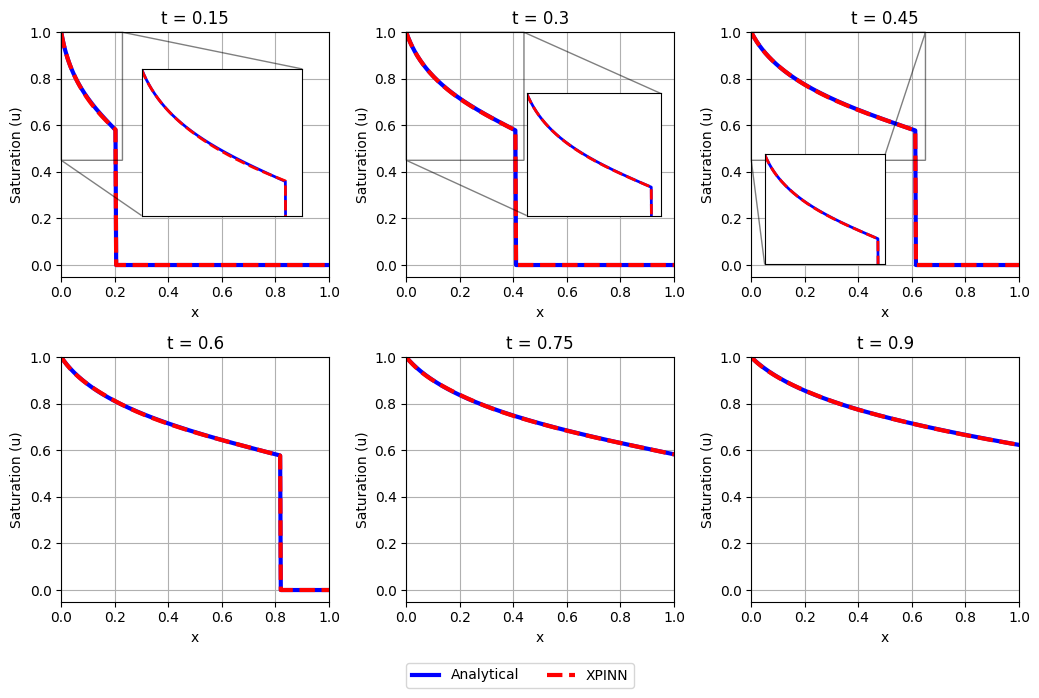

In [ ]:
# --- Reproducibility ---
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


t_plot = [0.15, 0.3, 0.45, 0.6, 0.75, 0.9]
x_vals = np.linspace(0, 1, 401)

U_prediction_jump = prediction_xpinn(x_vals, t_plot, xpinn_jump_W1, xpinn_jump_b1, xpinn_jump_A1, xpinn_jump_W2, xpinn_jump_b2, xpinn_jump_A2)

# --- Setup plots ---
ncols = 3
nrows = math.ceil(len(t_plot) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3.5, nrows * 3.5))
axes = np.array(axes).reshape(-1)

# Zoomed plot custom inset layout
custom_inset_params = {
    0: [0.3, 0.25, 0.6, 0.6],
    1: [0.45, 0.25, 0.50, 0.50],
    2: [0.05, 0.05, 0.45, 0.45],
}

for i, t_val in enumerate(t_plot):
    ax = axes[i]

    u_exact = np.array([u_analytic(xi, t_val) for xi in x_vals])
    u_model = U_prediction_jump[i]

    ax.plot(x_vals, u_exact, color="blue", ls="-", lw=3, label="Analytical")
    ax.plot(x_vals, u_model, color="red", ls="--", lw=3, label="XPINN")
    ax.set_title(f"t = {t_val}")
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05, 1)
    ax.grid(True)
    ax.set(xlabel="x", ylabel="Saturation (u)")

    if i < 3:
        x_shock = s * t_val
        mask_before = x_vals < x_shock
        x_before = x_vals[mask_before]
        u_before = u_exact[mask_before]

        if len(x_before) > 10:
            shock_u_value = u_exact[x_vals >= x_shock][0] if np.any(x_vals >= x_shock) else u_before[-1]
            tol_high = 0.98 * u_before.max()
            tol_low = shock_u_value + 0.02
            rare_mask = (u_before < tol_high) & (u_before > tol_low)

            if np.any(rare_mask):
                rare_idx = np.where(rare_mask)[0]
                rare_start = x_before[rare_idx[0]]
                rare_end = x_before[rare_idx[-1]]

                pad = 0.02
                zoom_xmin = max(0, rare_start - pad)
                zoom_xmax = min(1.0, rare_end + pad + 0.03 * (x_shock - rare_start))
                zoom_ymin = max(0, min(u_before[rare_idx].min(), 0.5) - 0.05)
                zoom_ymax = min(1, u_before[rare_idx].max() + 0.05)

                inset_pos = custom_inset_params.get(i, [0.5, 0.55, 0.35, 0.35])
                ax_inset = ax.inset_axes(inset_pos, transform=ax.transAxes)

                x_zoom = np.linspace(zoom_xmin, zoom_xmax, 201)
                X_zoom_tf = tf.concat([
                    tf.convert_to_tensor(x_zoom.reshape(-1, 1), dtype=tf.float32),
                    tf.fill((len(x_zoom), 1), float(t_val))
                ], axis=1)

                x_shock_zoom = s * t_val
                mask_before_zoom = x_zoom < x_shock_zoom
                mask_after_zoom = ~mask_before_zoom
                u_model_zoom = np.zeros_like(x_zoom)

                if np.any(mask_before_zoom):
                    u_model_zoom[mask_before_zoom] = neural_net(X_zoom_tf[mask_before_zoom], xpinn_jump_W1, xpinn_jump_b1, xpinn_jump_A1).numpy().flatten()
                if np.any(mask_after_zoom):
                    u_model_zoom[mask_after_zoom] = neural_net(X_zoom_tf[mask_after_zoom], xpinn_jump_W2, xpinn_jump_b2, xpinn_jump_A2).numpy().flatten()

                u_exact_zoom = np.array([u_analytic(xi, t_val) for xi in x_zoom])

                ax_inset.plot(x_zoom, u_exact_zoom, color="blue", lw=2)
                ax_inset.plot(x_zoom, u_model_zoom, color="red", ls="--", lw=2)
                ax_inset.set_xlim(zoom_xmin, zoom_xmax)
                ax_inset.set_ylim(zoom_ymin, zoom_ymax)
                ax_inset.grid(True, alpha=0.4)

                ax_inset.set_xticks([])
                ax_inset.set_yticks([])
                ax_inset.set_xlabel("")
                ax_inset.set_ylabel("")
                ax_inset.set_title("")

                ax.indicate_inset_zoom(ax_inset, edgecolor="black", alpha=0.5)

# Hide unused axes
for j in range(len(t_plot), len(axes)):
    axes[j].axis("off")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


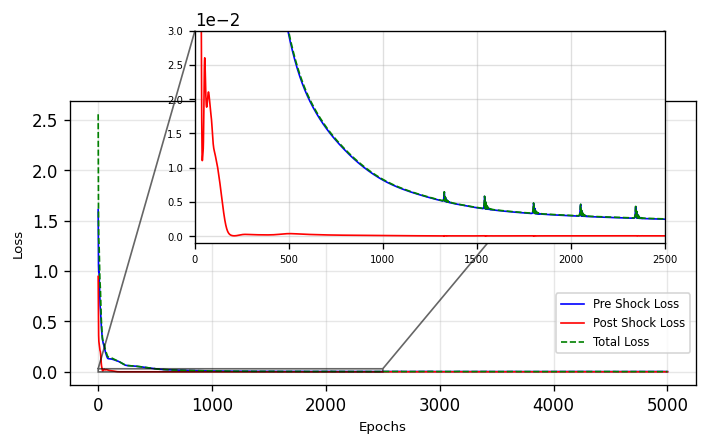

In [ ]:
# --- Convert loss histories ---
xpinn_jump_loss1_history = np.array(xpinn_jump_loss1_history)
xpinn_jump_loss2_history = np.array(xpinn_jump_loss2_history)
epoch_history = np.array(epoch_history)


fig, ax = plt.subplots(figsize=(6, 4), dpi=120)

ax.plot(epoch_history, xpinn_jump_loss1_history, 'b-', linewidth=1, label='Pre Shock Loss')
ax.plot(epoch_history, xpinn_jump_loss2_history, 'r-', linewidth=1, label='Post Shock Loss')
ax.plot(epoch_history, xpinn_jump_loss1_history + xpinn_jump_loss2_history, 'g--', linewidth=1, label='Total Loss')

ax.set_xlabel('Epochs', fontsize=8)
ax.set_ylabel('Loss', fontsize=8)
ax.legend(fontsize=7, loc='lower right', bbox_to_anchor=(1, 0.09))
ax.grid(True, alpha=0.3)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- zoomed plot ---
ax_inset = ax.inset_axes([0.2, 0.5, 0.750, 0.750])

ax_inset.plot(epoch_history, xpinn_jump_loss1_history, 'b-', linewidth=1)
ax_inset.plot(epoch_history, xpinn_jump_loss2_history, 'r-', linewidth=1)
ax_inset.plot(epoch_history, xpinn_jump_loss1_history + xpinn_jump_loss2_history, 'g--', linewidth=1)

ax_inset.set_xlim(0, 2500)
ax_inset.set_ylim(-0.001, 0.03)

ax_inset.grid(True, alpha=0.4)
ax_inset.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax_inset.tick_params(axis='both', labelsize=6)
ax.indicate_inset_zoom(ax_inset, edgecolor="black", alpha=0.6)
plt.tight_layout()
plt.show()

# Training XPINN without Jump condition and with best weight

In [ ]:
# Reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Neural network architectures 1
#layers1 = [2, 10, 1]
#layers2 = [2, 10, 1]

epochs = 5001

# Neural network architectures 2
layers1 = [2, 30, 20, 1]
layers2 = [2, 10, 1]

xpinn_no_jump_W1, xpinn_no_jump_b1, xpinn_no_jump_A1 = initialize_NN(layers1)
xpinn_no_jump_W2, xpinn_no_jump_b2, xpinn_no_jump_A2 = initialize_NN(layers2)

# Optimizers
lr1 = 1e-3
lr2 = 1e-3
optimizer1 = tf.optimizers.Adam(learning_rate=lr1)
optimizer2 = tf.optimizers.Adam(learning_rate=lr2)


# Create trainable variable lists
trainable_vars1 = xpinn_no_jump_W1 + xpinn_no_jump_b1 + xpinn_no_jump_A1
trainable_vars2 = xpinn_no_jump_W2 + xpinn_no_jump_b2 + xpinn_no_jump_A2

# Initialize optimizer variables by applying zero gradients
zero_grads1 = [tf.zeros_like(w) for w in trainable_vars1]
zero_grads2 = [tf.zeros_like(w) for w in trainable_vars2]

optimizer1.apply_gradients(zip(zero_grads1, trainable_vars1))
optimizer2.apply_gradients(zip(zero_grads2, trainable_vars2))

# Initialize loss histories
xpinn_no_jump_loss1_history, xpinn_no_jump_loss2_history, xpinn_no_jump_total_loss_history, epoch_history = [], [], [], []

# Best tracking variables
best_total_loss_xpinn_no_jump = float("inf")
best_loss1_xpinn_no_jump = best_loss2_xpinn_no_jump = None
best_xpinn_no_jump_W1 = best_xpinn_no_jump_b1 = best_xpinn_no_jump_A1 = None
best_xpinn_no_jump_W2 = best_xpinn_no_jump_b2 = best_xpinn_no_jump_A2 = None


# Train XPINN
print("Training XPINN without Jump condition...")

# Start timing
start_time_xpinn_no_jump = time.time()

for m in range(epochs + 1):

    loss1, loss2 = train_xpinn(xpinn_no_jump_W1, xpinn_no_jump_b1, xpinn_no_jump_A1, xpinn_no_jump_W2, xpinn_no_jump_b2, xpinn_no_jump_A2, X_ub_train_tf, ub_train_tf,
                                X_f1_train_tf, X_f2_train_tf, X_fi1_train_tf,
                                optimizer1, optimizer2, jump = False)

    l1, l2 = float(loss1.numpy()), float(loss2.numpy())
    total = l1 + l2

    # Store losses for plotting
    xpinn_no_jump_loss1_history.append(l1)
    xpinn_no_jump_loss2_history.append(l2)
    xpinn_no_jump_total_loss_history.append(total)
    epoch_history.append(m)

    # Track best model
    if total < best_total_loss_xpinn_no_jump:
        best_total_loss_xpinn_no_jump = total
        best_loss1_xpinn_no_jump, best_loss2_xpinn_no_jump = l1, l2
        best_xpinn_no_jump_W1 = copy.deepcopy(xpinn_no_jump_W1)
        best_xpinn_no_jump_b1 = copy.deepcopy(xpinn_no_jump_b1)
        best_xpinn_no_jump_A1 = copy.deepcopy(xpinn_no_jump_A1)
        best_xpinn_no_jump_W2 = copy.deepcopy(xpinn_no_jump_W2)
        best_xpinn_no_jump_b2 = copy.deepcopy(xpinn_no_jump_b2)
        best_xpinn_no_jump_A2 = copy.deepcopy(xpinn_no_jump_A2)

    # Print periodically
    if m % 500 == 0:
        print(f"Epoch {m:4d}: "
              f"Loss1={l1:.4e}, Loss2={l2:.4e}, Total loss={total:.4e} | "
              f"Best so far → Loss1={best_loss1_xpinn_no_jump:.4e}, Loss2={best_loss2_xpinn_no_jump:.4e}, Total={best_total_loss_xpinn_no_jump:.4e} ")

# Calculate total training time
total_training_time_xpinn_no_jump = time.time() - start_time_xpinn_no_jump

# Restore best weights
print("Restoring best weights...")
for i in range(len(xpinn_no_jump_W1)):
    xpinn_no_jump_W1[i].assign(best_xpinn_no_jump_W1[i])
for i in range(len(xpinn_no_jump_b1)):
    xpinn_no_jump_b1[i].assign(best_xpinn_no_jump_b1[i])
for i in range(len(xpinn_no_jump_A1)):
    xpinn_no_jump_A1[i].assign(best_xpinn_no_jump_A1[i])

for i in range(len(xpinn_no_jump_W2)):
    xpinn_no_jump_W2[i].assign(best_xpinn_no_jump_W2[i])
for i in range(len(xpinn_no_jump_b2)):
    xpinn_no_jump_b2[i].assign(best_xpinn_no_jump_b2[i])
for i in range(len(xpinn_no_jump_A2)):
    xpinn_no_jump_A2[i].assign(best_xpinn_no_jump_A2[i])


print(f"\n XPINN without Jump condition Training completed!")
print(f"   Total training time of XPINN: {total_training_time_xpinn_no_jump:.2f} seconds for {epochs} epochs")
print(f"   Best Loss1 = {best_loss1_xpinn_no_jump:.4e}")
print(f"   Best Loss2 = {best_loss2_xpinn_no_jump:.4e}")
print(f"   Best Total = {best_total_loss_xpinn_no_jump:.4e}")


Training XPINN without Jump condition...
Epoch    0: Loss1=6.7736e-01, Loss2=1.4225e-02, Total loss=6.9158e-01 | Best so far → Loss1=6.7736e-01, Loss2=1.4225e-02, Total=6.9158e-01 
Epoch  500: Loss1=1.5294e-02, Loss2=1.9431e-06, Total loss=1.5296e-02 | Best so far → Loss1=1.5294e-02, Loss2=1.9431e-06, Total=1.5296e-02 
Epoch 1000: Loss1=4.7404e-03, Loss2=2.5831e-07, Total loss=4.7407e-03 | Best so far → Loss1=4.6864e-03, Loss2=2.5992e-07, Total=4.6867e-03 
Epoch 1500: Loss1=3.2841e-03, Loss2=6.9646e-08, Total loss=3.2841e-03 | Best so far → Loss1=3.2841e-03, Loss2=6.9646e-08, Total=3.2841e-03 
Epoch 2000: Loss1=2.6889e-03, Loss2=2.5377e-08, Total loss=2.6889e-03 | Best so far → Loss1=2.6885e-03, Loss2=2.5470e-08, Total=2.6885e-03 
Epoch 2500: Loss1=2.1906e-03, Loss2=1.0898e-08, Total loss=2.1906e-03 | Best so far → Loss1=2.1906e-03, Loss2=1.0898e-08, Total=2.1906e-03 
Epoch 3000: Loss1=1.8666e-03, Loss2=5.1790e-09, Total loss=1.8666e-03 | Best so far → Loss1=1.8666e-03, Loss2=5.1790e-0

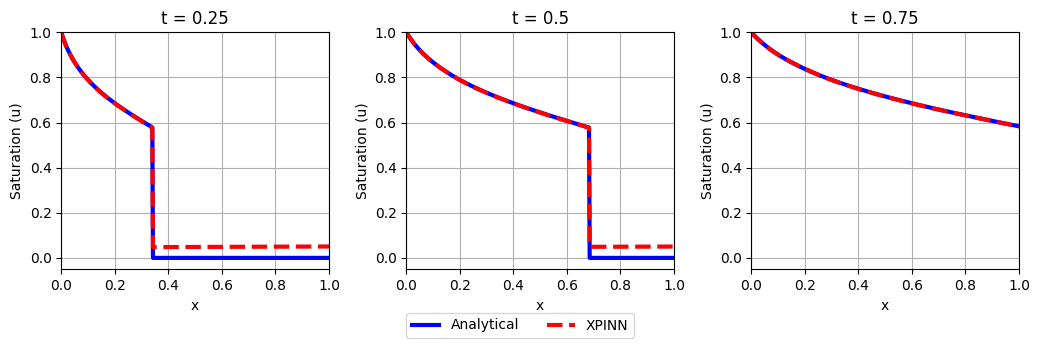

In [ ]:
t_plot = [0.25, 0.5, 0.75]
x_vals = np.linspace(0, 1, 401)

U_prediction_no_jump = prediction_xpinn(x_vals, t_plot, xpinn_no_jump_W1, xpinn_no_jump_b1, xpinn_no_jump_A1, xpinn_no_jump_W2, xpinn_no_jump_b2, xpinn_no_jump_A2)

# --- Setup plots ---
ncols = 3
nrows = math.ceil(len(t_plot) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3.5, nrows * 3.5))
axes = np.array(axes).reshape(-1)

for i, t_val in enumerate(t_plot):
    ax = axes[i]

    u_exact = np.array([u_analytic(xi, t_val) for xi in x_vals])
    u_model = U_prediction_no_jump[i]

    ax.plot(x_vals, u_exact, color="blue", ls="-", lw=3, label="Analytical")
    ax.plot(x_vals, u_model, color="red", ls="--", lw=3, label="XPINN")

    ax.set_title(f"t = {t_val}")
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.05, 1)
    ax.grid(True)
    ax.set(xlabel="x", ylabel="Saturation (u)")

# Hide unused axes
for j in range(len(t_plot), len(axes)):
    axes[j].axis("off")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center",
           bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

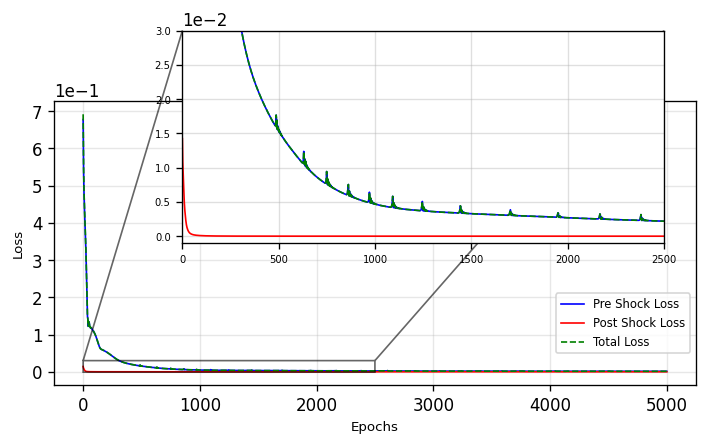

In [ ]:
# --- Convert loss histories ---
xpinn_no_jump_loss1_history = np.array(xpinn_no_jump_loss1_history)
xpinn_no_jump_loss2_history = np.array(xpinn_no_jump_loss2_history)
epoch_history = np.array(epoch_history)


fig, ax = plt.subplots(figsize=(6, 4), dpi=120)

ax.plot(epoch_history, xpinn_no_jump_loss1_history, 'b-', linewidth=1, label='Pre Shock Loss')
ax.plot(epoch_history, xpinn_no_jump_loss2_history, 'r-', linewidth=1, label='Post Shock Loss')
ax.plot(epoch_history, xpinn_no_jump_loss1_history + xpinn_no_jump_loss2_history, 'g--', linewidth=1, label='Total Loss')

ax.set_xlabel('Epochs', fontsize=8)
ax.set_ylabel('Loss', fontsize=8)
ax.legend(fontsize=7, loc='lower right', bbox_to_anchor=(1, 0.09))
ax.grid(True, alpha=0.3)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# --- zoomed plot ---
ax_inset = ax.inset_axes([0.2, 0.5, 0.750, 0.750])

ax_inset.plot(epoch_history, xpinn_no_jump_loss1_history, 'b-', linewidth=1)
ax_inset.plot(epoch_history, xpinn_no_jump_loss2_history, 'r-', linewidth=1)
ax_inset.plot(epoch_history, xpinn_no_jump_loss1_history + xpinn_no_jump_loss2_history, 'g--', linewidth=1)

ax_inset.set_xlim(0, 2500)
ax_inset.set_ylim(-0.001, 0.03)

ax_inset.grid(True, alpha=0.4)
ax_inset.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax_inset.tick_params(axis='both', labelsize=6)
ax.indicate_inset_zoom(ax_inset, edgecolor="black", alpha=0.6)
plt.tight_layout()
plt.show()

# Standard PINN Data preparation

Just stack collocation_before_shock, collocation_on_shock, and collocation_after_shock together to have one full dataset.

In [ ]:
# PINN training data

X_colloc_pinn = tf.convert_to_tensor(np.vstack([collocation_before_shock,collocation_on_shock,collocation_after_shock]),dtype=tf.float32)
X_bc_pinn = tf.convert_to_tensor(np.vstack([data_initial, data_bc_0]), dtype=tf.float32)
u_bc_pinn = tf.convert_to_tensor(np.vstack([np.zeros_like(data_initial[:, 0:1]), np.ones_like(data_bc_0[:, 0:1])]), dtype=tf.float32)

# Or increase the Collocation points for standard PINNs:

"""N_colloc = 10000

x_c = np.random.uniform(0, x_max, (N_colloc, 1))
t_c = np.random.uniform(0, t_max, (N_colloc, 1))

X_colloc_pinn = tf.convert_to_tensor(np.hstack([x_c, t_c]), dtype=tf.float32)"""


'N_colloc = 10000\n\nx_c = np.random.uniform(0, x_max, (N_colloc, 1))\nt_c = np.random.uniform(0, t_max, (N_colloc, 1))\n\nX_colloc_pinn = tf.convert_to_tensor(np.hstack([x_c, t_c]), dtype=tf.float32)'

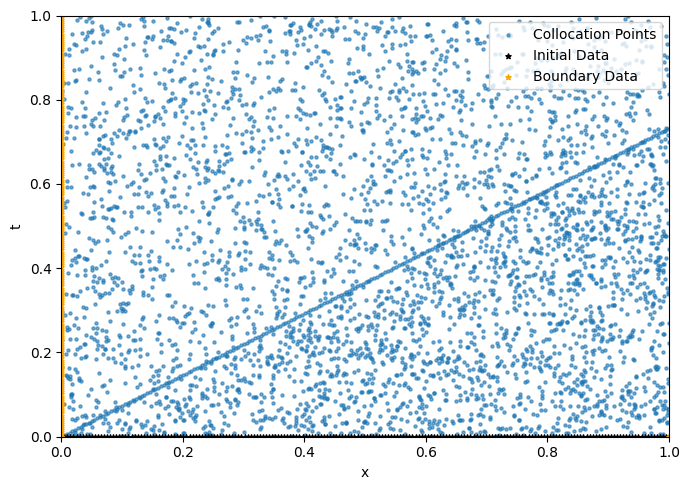

In [ ]:
# Plot Standard PINN data

# Convert to NumPy
X_bc = X_bc_pinn.numpy()
X_col = X_colloc_pinn.numpy()

# Extract coordinates
x_bc, t_bc = X_bc[:, 0], X_bc[:, 1]
x_col, t_col = X_col[:, 0], X_col[:, 1]

# Initial & boundary points
initial_idx  = (t_bc == 0)                        # initial condition
boundary_idx = (x_bc == 0) | (x_bc == 1)          # boundary condition

x_init,  t_init  = x_bc[initial_idx],  t_bc[initial_idx]
x_bound, t_bound = x_bc[boundary_idx], t_bc[boundary_idx]

# Plot
plt.figure(figsize=(7,5))

plt.scatter(x_col,   t_col,   s=5,  alpha=0.6, label="Collocation Points")
plt.scatter(x_init,  t_init,  s=15, color="black",    label="Initial Data", marker='*')
plt.scatter(x_bound, t_bound, s=15, color="orange",   label="Boundary Data", marker='*')

plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


# PINN and its variants Implementation

It has epsilon and entropy arguments to have:
1. Standard PINN (epsilon = 0, Entropy = "None")
2. PINN with Diffusivity term (epsilon = 2.5e-3, Entropy = "None")
3. PINN with Welge Construction (epsilon = 0, Entropy = "Welge")
4. PINN with Oleinik Entropy Condition (epsilon = 0, Entropy = "Oleinik")

In [ ]:
# PINN functions

@tf.function
def residual_pinn(X, W, b, A, entropy="None", epsilon=0.0):
    x = X[:, 0:1]
    t = X[:, 1:2]

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, t])
        u_pred = neural_net(tf.concat([x, t], axis=1), W, b, A)

        # flux selector
        if entropy == "Welge":
            print("Using Welge Construction")
            f_u = f_w_entropy_welge(u_pred)
        elif entropy == "Oleinik":
            print("Using Oleinik Entropy")
            f_u = f_w_entropy_oleinik(u_pred)
        else:
            print("Entropy None")
            f_u = f_w(u_pred)

        # first derivatives
        u_t = tape.gradient(u_pred, t)
        f_x = tape.gradient(f_u, x)

        # second derivative for viscosity (diffusivity), computed only if epsilon != 0
        u_xx = tape.gradient(tape.gradient(u_pred, x), x) if epsilon != 0.0 else tf.zeros_like(x)
        visc_term = epsilon * u_xx if epsilon != 0.0 else tf.zeros_like(x)

    del tape
    return u_t + f_x - visc_term

@tf.function
def train_pinn(X_colloc, X_bc, u_bc, W, b, A, optimizer, epsilon=0.0, entropy="None"):

    with tf.GradientTape() as tape:

        # PDE residual
        f_pred = residual_pinn(X_colloc, W, b, A, epsilon=epsilon, entropy=entropy)
        pde_loss = tf.reduce_mean(tf.square(f_pred))

        # Boundary/initial conditions
        u_pred = neural_net(X_bc, W, b, A)
        bc_loss = tf.reduce_mean(tf.square(u_bc - u_pred))

        # Total loss
        total_loss = pde_loss + bc_loss

    grads = tape.gradient(total_loss, W + b + A)
    optimizer.apply_gradients(zip(grads, W + b + A))
    del tape

    return total_loss


# Training Standard PINN with best weight

In [ ]:
# Reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

pinn_layers =  [2, 30, 22, 1]  #[2, 20, 20, 20,20, 20, 20,20,20, 1]
epochs = epochs #2001

pinn_W, pinn_b, pinn_A = initialize_NN(pinn_layers)

# Optimizers
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

# Create trainable variable lists
trainable_vars = pinn_W + pinn_b + pinn_A

# Initialize optimizer variables by applying zero gradients
zero_grads = [tf.zeros_like(w) for w in trainable_vars]

optimizer.apply_gradients(zip(zero_grads, trainable_vars))

# Initialize loss histories
pinn_loss_history, epoch_history = [], []

# Best tracking variables
best_total_loss_pinn = float("inf")
best_loss_pinn = None
best_pinn_W = best_pinn_b = best_pinn_A = None

# Train PINN
print("Training Standard PINN...")

# Start timing
start_time_pinn = time.time()

for m in range(epochs + 1):

    pinn_loss= train_pinn(X_colloc_pinn, X_bc_pinn, u_bc_pinn, pinn_W, pinn_b, pinn_A, optimizer,epsilon=0.0, entropy="None")

    l1 = float(pinn_loss.numpy())
    total = l1

    # Store losses for plotting
    pinn_loss_history.append(l1)
    epoch_history.append(m)

    # Track best model
    if total < best_total_loss_pinn:
        best_total_loss_pinn = total
        best_loss_pinn = l1
        best_pinn_W = copy.deepcopy(pinn_W)
        best_pinn_b = copy.deepcopy(pinn_b)
        best_pinn_A = copy.deepcopy(pinn_A)

    # Print periodically
    if m % 500 == 0:
        print(f"Epoch {m:4d}: "
              f"Loss={l1:.4e}, | "
              f"Best so far → Loss={best_loss_pinn:.4e}")

# Calculate total training time
total_training_time_pinn = time.time() - start_time_pinn

# Restore best weights
print("Restoring best weights...")
for i in range(len(pinn_W)):
    pinn_W[i].assign(best_pinn_W[i])
for i in range(len(pinn_b)):
    pinn_b[i].assign(best_pinn_b[i])
for i in range(len(pinn_A)):
    pinn_A[i].assign(best_pinn_A[i])


print(f"\n Standard PINN Training completed!")
print(f"   Total training time of PINN: {total_training_time_pinn:.2f} seconds for {epochs} epochs")
print(f"   Best Loss = {best_loss_pinn:.4e}")


Training Standard PINN...


Entropy None
Epoch    0: Loss=6.1171e-01, | Best so far → Loss=6.1171e-01
Epoch  500: Loss=4.9517e-02, | Best so far → Loss=4.9517e-02
Epoch 1000: Loss=3.2896e-02, | Best so far → Loss=3.0184e-02
Epoch 1500: Loss=2.5429e-02, | Best so far → Loss=2.5429e-02
Epoch 2000: Loss=2.3948e-02, | Best so far → Loss=2.3948e-02
Epoch 2500: Loss=2.3166e-02, | Best so far → Loss=2.3164e-02
Epoch 3000: Loss=2.2432e-02, | Best so far → Loss=2.2432e-02
Epoch 3500: Loss=2.2221e-02, | Best so far → Loss=2.1914e-02
Epoch 4000: Loss=2.1670e-02, | Best so far → Loss=2.1551e-02
Epoch 4500: Loss=2.1672e-02, | Best so far → Loss=2.1268e-02
Epoch 5000: Loss=2.0987e-02, | Best so far → Loss=2.0984e-02
Restoring best weights...

 Standard PINN Training completed!
   Total training time of PINN: 61.47 seconds for 5001 epochs
   Best Loss = 2.0984e-02


# Training PINN with diffusivity term and with best weight

In [ ]:
# Reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#pinn_layers = pinn_layers #[2, 20, 20, 20,20, 20, 20,20,20, 1]
epochs = epochs

pinn_diffusivity_W, pinn_diffusivity_b, pinn_diffusivity_A = initialize_NN(pinn_layers)

# Optimizers
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

# Create trainable variable lists
trainable_vars = pinn_diffusivity_W + pinn_diffusivity_b + pinn_diffusivity_A


# Initialize optimizer variables by applying zero gradients
zero_grads = [tf.zeros_like(w) for w in trainable_vars]

optimizer.apply_gradients(zip(zero_grads, trainable_vars))

# Initialize loss histories
pinn_diffusivity_loss_history, epoch_history = [], []

# Best tracking variables
best_total_loss_pinn_diffusivity = float("inf")
best_loss_pinn_diffusivity = None
best_pinn_diffusivity_W = best_pinn_diffusivity_b = best_pinn_diffusivity_A = None

# Train PINN_diffusivity
print("Training PINN with diffusivity...")

# Start timing
start_time_pinn_diffusivity = time.time()

for m in range(epochs + 1):

    pinn_diffusivity_loss= train_pinn(X_colloc_pinn, X_bc_pinn, u_bc_pinn, pinn_diffusivity_W, pinn_diffusivity_b, pinn_diffusivity_A, optimizer,epsilon=2.5e-3, entropy="None")

    l1 = float(pinn_diffusivity_loss.numpy())
    total = l1

    # Store losses for plotting
    pinn_diffusivity_loss_history.append(l1)
    epoch_history.append(m)

    # Track best model
    if total < best_total_loss_pinn_diffusivity:
        best_total_loss_pinn_diffusivity = total
        best_loss_pinn_diffusivity = l1
        best_pinn_diffusivity_W = copy.deepcopy(pinn_diffusivity_W)
        best_pinn_diffusivity_b = copy.deepcopy(pinn_diffusivity_b)
        best_pinn_diffusivity_A = copy.deepcopy(pinn_diffusivity_A)

    # Print periodically
    if m % 500 == 0:
        print(f"Epoch {m:4d}: "
              f"Loss={l1:.4e}, | "
              f"Best so far → Loss={best_loss_pinn_diffusivity:.4e}")

# Calculate total training time
total_training_time_pinn_diffusivity = time.time() - start_time_pinn_diffusivity

# Restore best weights
print("Restoring best weights...")
for i in range(len(pinn_diffusivity_W)):
    pinn_diffusivity_W[i].assign(best_pinn_diffusivity_W[i])
for i in range(len(pinn_diffusivity_b)):
    pinn_diffusivity_b[i].assign(best_pinn_diffusivity_b[i])
for i in range(len(pinn_diffusivity_A)):
    pinn_diffusivity_A[i].assign(best_pinn_diffusivity_A[i])


print(f"\n PINN with diffusivity Training completed!")
print(f"   Total training time of PINN with diffusivity: {total_training_time_pinn_diffusivity:.2f} seconds for {epochs} epochs")
print(f"   Best Loss = {best_loss_pinn_diffusivity:.4e}")


Training PINN with diffusivity...
Entropy None
Epoch    0: Loss=6.1167e-01, | Best so far → Loss=6.1167e-01
Epoch  500: Loss=4.9355e-02, | Best so far → Loss=4.9355e-02
Epoch 1000: Loss=2.9808e-02, | Best so far → Loss=2.9808e-02
Epoch 1500: Loss=2.5148e-02, | Best so far → Loss=2.4656e-02
Epoch 2000: Loss=2.2937e-02, | Best so far → Loss=2.2936e-02
Epoch 2500: Loss=2.1698e-02, | Best so far → Loss=2.1698e-02
Epoch 3000: Loss=1.9696e-02, | Best so far → Loss=1.9645e-02
Epoch 3500: Loss=1.8016e-02, | Best so far → Loss=1.7993e-02
Epoch 4000: Loss=1.6348e-02, | Best so far → Loss=1.6192e-02
Epoch 4500: Loss=2.7702e-02, | Best so far → Loss=1.5751e-02
Epoch 5000: Loss=2.5880e-02, | Best so far → Loss=1.5751e-02
Restoring best weights...

 PINN with diffusivity Training completed!
   Total training time of PINN with diffusivity: 90.89 seconds for 5001 epochs
   Best Loss = 1.5751e-02


# Training PINN with Welge Construction and with best weight

In [ ]:
# Fractional flow function with Welge Construction

def f_w_entropy_welge(u):
    condition1 = u <= 0
    condition2 = (0 < u) & (u <= u_star)
    condition3 = u > u_star

    zero_tensor = tf.zeros_like(u, dtype=tf.float32)

    value1 = zero_tensor
    value2 = (u ) / f_w(u_star)
    value3 = tf.square(u) / (tf.square(u) + tf.square(1 - u) / M)

    result = tf.where(condition1, value1,
             tf.where(condition2, value2, value3))

    return result


In [ ]:
# Reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#pinn_layers = pinn_layers #[2, 20, 20, 20,20, 20, 20,20,20, 1]
epochs =  epochs

pinn_Welge_W, pinn_Welge_b, pinn_Welge_A = initialize_NN(pinn_layers)

# Optimizers
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

# Create trainable variable lists
trainable_vars = pinn_Welge_W + pinn_Welge_b + pinn_Welge_A

# Initialize optimizer variables by applying zero gradients
zero_grads = [tf.zeros_like(w) for w in trainable_vars]

optimizer.apply_gradients(zip(zero_grads, trainable_vars))

# Initialize loss histories
pinn_Welge_loss_history, epoch_history = [], []

# Best tracking variables
best_total_loss_pinn_Welge = float("inf")
best_loss_pinn_Welge = None
best_pinn_Welge_W = best_pinn_Welge_b = best_pinn_Welge_A = None

# Train PINN with Welge Construction
print("Training PINN with Welge Construction...")
# Start timing
start_time_pinn_Welge = time.time()

for m in range(epochs + 1):

    pinn_Welge_loss= train_pinn(X_colloc_pinn, X_bc_pinn, u_bc_pinn, pinn_Welge_W, pinn_Welge_b, pinn_Welge_A, optimizer,epsilon=0, entropy="Welge")

    l1 = float(pinn_Welge_loss.numpy())
    total = l1

    # Store losses for plotting
    pinn_Welge_loss_history.append(l1)
    epoch_history.append(m)

    # Track best model
    if total < best_total_loss_pinn_Welge:
        best_total_loss_pinn_Welge = total
        best_loss_pinn_Welge = l1
        best_pinn_Welge_W = copy.deepcopy(pinn_Welge_W)
        best_pinn_Welge_b = copy.deepcopy(pinn_Welge_b)
        best_pinn_Welge_A = copy.deepcopy(pinn_Welge_A)

    # Print periodically
    if m % 500 == 0:
        print(f"Epoch {m:4d}: "
              f"Loss={l1:.4e}, | "
              f"Best so far → Loss={best_loss_pinn_Welge:.4e}")

# Calculate total training time
total_training_time_pinn_Welge =  time.time() - start_time_pinn_Welge

# Restore best weights
print("Restoring best weights...")
for i in range(len(pinn_Welge_W)):
    pinn_Welge_W[i].assign(best_pinn_Welge_W[i])
for i in range(len(pinn_Welge_b)):
    pinn_Welge_b[i].assign(best_pinn_Welge_b[i])
for i in range(len(pinn_Welge_A)):
    pinn_Welge_A[i].assign(best_pinn_Welge_A[i])


print(f"\n PINN with Welge Construction Training completed!")
print(f"   Total training time of PINN with Welge Construction: {total_training_time_pinn_Welge:.2f} seconds for {epochs} epochs")
print(f"   Best Loss = {best_loss_pinn_Welge:.4e}")


Training PINN with Welge Construction...
Using Welge Construction
Epoch    0: Loss=6.1845e-01, | Best so far → Loss=6.1845e-01
Epoch  500: Loss=2.6616e-02, | Best so far → Loss=1.9472e-02
Epoch 1000: Loss=9.0309e-03, | Best so far → Loss=8.8430e-03
Epoch 1500: Loss=1.1141e-02, | Best so far → Loss=8.1088e-03
Epoch 2000: Loss=7.1029e-03, | Best so far → Loss=6.5875e-03
Epoch 2500: Loss=1.0348e-02, | Best so far → Loss=6.2098e-03
Epoch 3000: Loss=9.8355e-03, | Best so far → Loss=6.2098e-03
Epoch 3500: Loss=1.0055e-02, | Best so far → Loss=6.2098e-03
Epoch 4000: Loss=1.6659e-01, | Best so far → Loss=6.2098e-03
Epoch 4500: Loss=1.2783e-02, | Best so far → Loss=6.2098e-03
Epoch 5000: Loss=8.0201e-03, | Best so far → Loss=6.2098e-03
Restoring best weights...

 PINN with Welge Construction Training completed!
   Total training time of PINN with Welge Construction: 53.07 seconds for 5001 epochs
   Best Loss = 6.2098e-03


# Training PINN with Oleinik Entropy Condition and with best weight

In [ ]:
# Fractional flow function with Oleinik Entropy Condition

sigma = f_w(u_star)/u_star # Shock speed, same as "s" defined above in a second cell

def f_w_entropy_oleinik(u):

    result= tf.where(u < u_star, sigma*u, f_w(u))

    return result


In [ ]:
# Reproducibility
seed = seed
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#pinn_layers = pinn_layers #[2, 20, 20, 20,20, 20, 20,20,20, 1]
epochs =  epochs #2001

pinn_Oleinik_W, pinn_Oleinik_b, pinn_Oleinik_A = initialize_NN(pinn_layers)

# Optimizers
lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

# Create trainable variable lists
trainable_vars = pinn_Oleinik_W + pinn_Oleinik_b + pinn_Oleinik_A

# Initialize optimizer variables by applying zero gradients
zero_grads = [tf.zeros_like(w) for w in trainable_vars]

optimizer.apply_gradients(zip(zero_grads, trainable_vars))

# Initialize loss histories
pinn_Oleinik_loss_history, epoch_history = [], []

# Best tracking variables
best_total_loss_pinn_Oleinik = float("inf")
best_loss_pinn_Oleinik = None
best_pinn_Oleinik_W = best_pinn_Oleinik_b = best_pinn_Oleinik_A = None

# Train PINN with Oleinik Entropy Condition
print("Training PINN with Oleinik Entropy Condition...")

# Start timing
start_time_pinn_Oleinik = time.time()

for m in range(epochs + 1):

    pinn_Oleinik_loss= train_pinn(X_colloc_pinn, X_bc_pinn, u_bc_pinn, pinn_Oleinik_W, pinn_Oleinik_b, pinn_Oleinik_A, optimizer,epsilon=0, entropy="Oleinik")

    l1 = float(pinn_Oleinik_loss.numpy())
    total = l1

    # Store losses for plotting
    pinn_Oleinik_loss_history.append(l1)
    epoch_history.append(m)

    # Track best model
    if total < best_total_loss_pinn_Oleinik:
        best_total_loss_pinn_Oleinik = total
        best_loss_pinn_Oleinik = l1
        best_pinn_Oleinik_W = copy.deepcopy(pinn_Oleinik_W)
        best_pinn_Oleinik_b = copy.deepcopy(pinn_Oleinik_b)
        best_pinn_Oleinik_A = copy.deepcopy(pinn_Oleinik_A)

    # Print periodically
    if m % 500 == 0:
        print(f"Epoch {m:4d}: "
              f"Loss={l1:.4e}, | "
              f"Best so far → Loss={best_loss_pinn_Oleinik:.4e}")

# Calculate total training time
total_training_time_pinn_Oleinik = time.time() - start_time_pinn_Oleinik

# Restore best weights
print("Restoring best weights...")
for i in range(len(pinn_Oleinik_W)):
    pinn_Oleinik_W[i].assign(best_pinn_Oleinik_W[i])
for i in range(len(pinn_Oleinik_b)):
    pinn_Oleinik_b[i].assign(best_pinn_Oleinik_b[i])
for i in range(len(pinn_Oleinik_A)):
    pinn_Oleinik_A[i].assign(best_pinn_Oleinik_A[i])


print(f"\n PINN with Oleinik Entropy Condition Training completed!")
print(f"   Total training time of PINN with entropy: {total_training_time_pinn_Oleinik:.2f} seconds for {epochs} epochs")
print(f"   Best Loss = {best_loss_pinn_Oleinik:.4e}")


Training PINN with Oleinik Entropy Condition...
Using Oleinik Entropy
Epoch    0: Loss=1.1165e+00, | Best so far → Loss=1.1165e+00
Epoch  500: Loss=4.9976e-02, | Best so far → Loss=4.9976e-02
Epoch 1000: Loss=1.5828e-02, | Best so far → Loss=1.5828e-02
Epoch 1500: Loss=8.6819e-03, | Best so far → Loss=8.6819e-03
Epoch 2000: Loss=4.9609e-03, | Best so far → Loss=4.9609e-03
Epoch 2500: Loss=3.6211e-03, | Best so far → Loss=3.6211e-03
Epoch 3000: Loss=3.0585e-03, | Best so far → Loss=3.0585e-03
Epoch 3500: Loss=2.7972e-03, | Best so far → Loss=2.7951e-03
Epoch 4000: Loss=2.8473e-03, | Best so far → Loss=2.6081e-03
Epoch 4500: Loss=2.6012e-03, | Best so far → Loss=2.5330e-03
Epoch 5000: Loss=2.3815e-03, | Best so far → Loss=2.3815e-03
Restoring best weights...

 PINN with Oleinik Entropy Condition Training completed!
   Total training time of PINN with entropy: 70.02 seconds for 5001 epochs
   Best Loss = 2.3811e-03


# Count trainable parameters for all networks

In [ ]:
# Function to count trainable parameters

def count_trainable_params_detailed(weights, biases, activations):

    weights_params = 0
    biases_params = 0
    activation_params = 0

    # Count weights
    for i, w in enumerate(weights):
        layer_weights = tf.reduce_prod(w.shape).numpy()
        weights_params += layer_weights

    # Count biases
    for i, b in enumerate(biases):
        layer_biases = tf.reduce_prod(b.shape).numpy()
        biases_params += layer_biases

    # Count activation parameters
    activation_params = len(activations)

    total_params = weights_params + biases_params + activation_params

    print(f"Total trainable parameters: {total_params:,} (Weights: {weights_params}, Biases: {biases_params}, A: {activation_params})")

    return total_params



In [ ]:
# Count trainable parameters for all networks
print(f"Trainable parameters breakdown:")
print()
print("\033[1mXPINN:\033[0m")
print(f"Pre-shcok Network _jump:")
params1_xpinn = count_trainable_params_detailed(xpinn_jump_W1, xpinn_jump_b1, xpinn_jump_A1)
print(f"Post-shock Network 2 _jump:")
params2_xpinn = count_trainable_params_detailed(xpinn_jump_W2, xpinn_jump_b2, xpinn_jump_A2)
total_params_xpinn = params1_xpinn + params2_xpinn
print(f"Total trainable parameters of XPINN _jump: {total_params_xpinn:,}")
print(f"Total training time of XPINN _jump: {total_training_time_xpinn_jump:.2f} seconds for {epochs} epochs")
print()

print(f"\033[1mStandard PINN:\033[0m")
total_params_pinn = count_trainable_params_detailed(pinn_W, pinn_b, pinn_A)
print(f"Total trainable parameters of Standard PINN: {total_params_pinn:,}")
print(f"Standard PINN has {total_params_pinn / total_params_xpinn:.2f}× more trainable parameters than XPINN _jump")
print(f"Total training time of Standard PINN: {total_training_time_pinn:.2f} seconds for {epochs} epochs")
print(f"Standard PINN takes {total_training_time_pinn / total_training_time_xpinn_jump:.2f}× more time to train than XPINN _jump")
print()

print(f"\033[1mPINN with Diffusivity term:\033[0m")
total_params_pinn_diffusivity = count_trainable_params_detailed(pinn_diffusivity_W, pinn_diffusivity_b, pinn_diffusivity_A)
print(f"Total trainable parameters of Standard PINN: {total_params_pinn_diffusivity:,}")
print(f"PINN with Diffusivity term has {total_params_pinn_diffusivity / total_params_xpinn:.2f}× more trainable parameters than XPINN _jump")
print(f"Total training time of PINN with Diffusivity: {total_training_time_pinn_diffusivity:.2f} seconds for {epochs} epochs")
print(f"PINN with Diffusivity term takes {total_training_time_pinn_diffusivity / total_training_time_xpinn_jump:.2f}× more time to train than XPINN _jump")
print()

print(f"\033[1mPINN with Welge Construction:\033[0m")
total_params_pinn_Welge = count_trainable_params_detailed(pinn_Welge_W, pinn_Welge_b, pinn_Welge_A)
print(f"Total trainable parameters of Standard PINN: {total_params_pinn_Welge:,}")
print(f"PINN with Welge Construction has {total_params_pinn_Welge/ total_params_xpinn:.2f}× more trainable parameters than XPINN _jump")
print(f"Total training time of PINN with Welge Construction: {total_training_time_pinn_Welge:.2f} seconds for {epochs} epochs")
print(f"PINN with Welge Construction takes {total_training_time_pinn_Welge / total_training_time_xpinn_jump:.2f}× more time to train than XPINN_jump")
print()

print(f"\033[1mPINN with Oleinik Entropy Condition:\033[0m")
total_params_pinn_Oleinik = count_trainable_params_detailed(pinn_Oleinik_W, pinn_Oleinik_b, pinn_Oleinik_A)
print(f"Total trainable parameters of Standard PINN: {total_params_pinn_Oleinik:,}")
print(f"PINN with Oleinik Entropy Condition has {total_params_pinn_Oleinik/ total_params_xpinn:.2f}× more trainable parameters than XPINN _jump")
print(f"Total training time of PINN with Oleinik Entropy Condition: {total_training_time_pinn_Oleinik:.2f} seconds for {epochs} epochs")
print(f"PINN with Oleinik Entropy Condition takes {total_training_time_pinn_Oleinik / total_training_time_xpinn_jump:.2f}× more time to train than XPINN_jump")




Trainable parameters breakdown:

XPINN:
Pre-shcok Network _jump:
Total trainable parameters: 734 (Weights: 680, Biases: 51, A: 3)
Post-shock Network 2 _jump:
Total trainable parameters: 43 (Weights: 30, Biases: 11, A: 2)
Total trainable parameters of XPINN _jump: 777
Total training time of XPINN _jump: 77.06 seconds for 5001 epochs

Standard PINN:
Total trainable parameters: 798 (Weights: 742, Biases: 53, A: 3)
Total trainable parameters of Standard PINN: 798
Standard PINN has 1.03× more trainable parameters than XPINN _jump
Total training time of Standard PINN: 61.47 seconds for 5001 epochs
Standard PINN takes 0.80× more time to train than XPINN _jump

PINN with Diffusivity term:
Total trainable parameters: 798 (Weights: 742, Biases: 53, A: 3)
Total trainable parameters of Standard PINN: 798
PINN with Diffusivity term has 1.03× more trainable parameters than XPINN _jump
Total training time of PINN with Diffusivity: 90.89 seconds for 5001 epochs
PINN with Diffusivity term takes 1.18× m

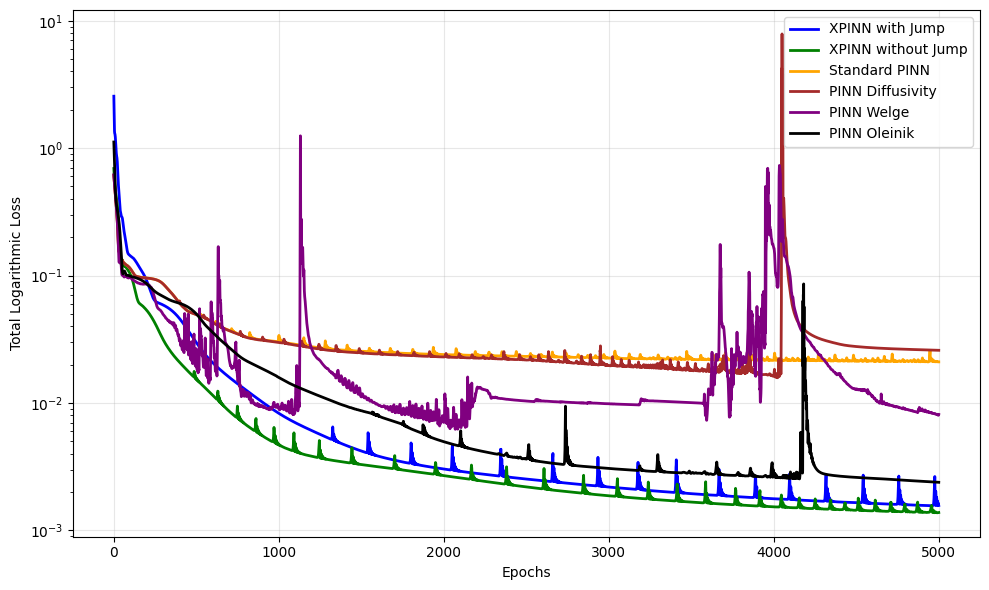

In [ ]:
# Convergence Comparison

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each model using its real epoch range
ax.semilogy(np.arange(len(xpinn_jump_total_loss_history)), xpinn_jump_total_loss_history, color='blue', label='XPINN with Jump', linewidth=2)
ax.semilogy(np.arange(len(xpinn_no_jump_total_loss_history)), xpinn_no_jump_total_loss_history, color='green', label='XPINN without Jump', linewidth=2)
ax.semilogy(np.arange(len(pinn_loss_history)), pinn_loss_history, 'orange', label='Standard PINN', linewidth=2)
ax.semilogy(np.arange(len(pinn_diffusivity_loss_history)), pinn_diffusivity_loss_history, 'brown', label='PINN Diffusivity', linewidth=2)
ax.semilogy(np.arange(len(pinn_Welge_loss_history)), pinn_Welge_loss_history, 'purple', label='PINN Welge', linewidth=2)
ax.semilogy(np.arange(len(pinn_Oleinik_loss_history)), pinn_Oleinik_loss_history, 'black', label='PINN Oleinik', linewidth=2)


# Labels, legend, and grid
ax.set_xlabel('Epochs')
ax.set_ylabel('Total Logarithmic Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Prediction Test set

In [ ]:
t_plot = [0.25, 0.5, 0.75]
#t_plot = [0.1, 0.15, 0.20] # For M = 30
x_vals = np.linspace(0, 1, 401)

U_prediction_jump = prediction_xpinn(
    x_vals, t_plot,
    xpinn_jump_W1, xpinn_jump_b1, xpinn_jump_A1,
    xpinn_jump_W2, xpinn_jump_b2, xpinn_jump_A2
)

U_prediction_no_jump = prediction_xpinn(
    x_vals, t_plot,
    xpinn_no_jump_W1, xpinn_no_jump_b1, xpinn_no_jump_A1,
    xpinn_no_jump_W2, xpinn_no_jump_b2, xpinn_no_jump_A2
)


# Predictions for other methods
U_prediction_pinn = []
U_prediction_pinn_diffusivity = []
U_prediction_pinn_Welge = []
U_prediction_pinn_Oleinik = []

for t_val in t_plot:
    X_test = np.column_stack([x_vals, np.full_like(x_vals, t_val)])

    # PINN prediction
    u_pinn = neural_net(tf.convert_to_tensor(X_test, dtype=tf.float32),
                        pinn_W, pinn_b, pinn_A).numpy().flatten()
    U_prediction_pinn.append(u_pinn)

    # PINN with Diffusivity prediction
    u_pinn_diffusivity = neural_net(tf.convert_to_tensor(X_test, dtype=tf.float32),
                                   pinn_diffusivity_W, pinn_diffusivity_b,
                                   pinn_diffusivity_A).numpy().flatten()
    U_prediction_pinn_diffusivity.append(u_pinn_diffusivity)

    # PINN with Welge Construction prediction
    u_pinn_entropy_Welge = neural_net(tf.convert_to_tensor(X_test, dtype=tf.float32),
                                      pinn_Welge_W, pinn_Welge_b,
                                      pinn_Welge_A).numpy().flatten()
    U_prediction_pinn_Welge.append(u_pinn_entropy_Welge)

    # PINN with Oleinik Entropy  prediction
    u_pinn_Oleinik = neural_net(tf.convert_to_tensor(X_test, dtype=tf.float32),
                                      pinn_Oleinik_W, pinn_Oleinik_b,
                                      pinn_Oleinik_A).numpy().flatten()
    U_prediction_pinn_Oleinik.append(u_pinn_Oleinik)

# Convert to numpy arrays
U_prediction_pinn = np.array(U_prediction_pinn)
U_prediction_pinn_diffusivity = np.array(U_prediction_pinn_diffusivity)
U_prediction_pinn_Welge = np.array(U_prediction_pinn_Welge)
U_prediction_pinn_Oleinik = np.array(U_prediction_pinn_Oleinik)


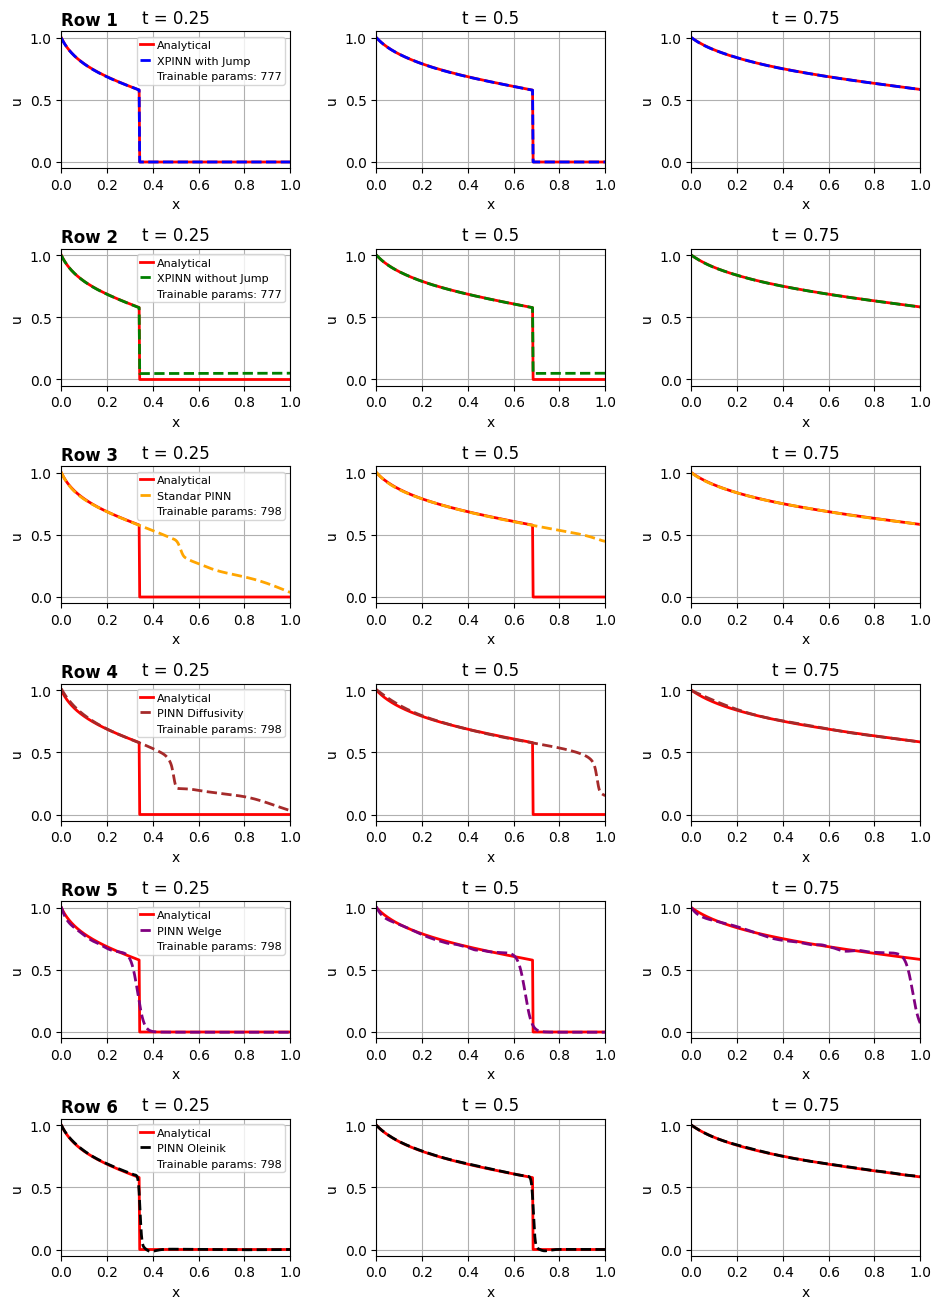

In [ ]:
# Visualization
from matplotlib.lines import Line2D

methods = [
    ("XPINN with Jump", U_prediction_jump, dict(color="blue", linestyle="--", lw=2), total_params_xpinn),
    ("XPINN without Jump", U_prediction_no_jump, dict(color="green", linestyle="--", lw=2), total_params_xpinn),
    ("Standar PINN", U_prediction_pinn, dict(color="orange", linestyle="--", lw=2), total_params_pinn),
    ("PINN Diffusivity", U_prediction_pinn_diffusivity, dict(color="brown", linestyle="--", lw=2), total_params_pinn_diffusivity),
    ("PINN Welge", U_prediction_pinn_Welge, dict(color="purple", linestyle="--", lw=2), total_params_pinn_Welge),
    ("PINN Oleinik", U_prediction_pinn_Oleinik, dict(color="black", linestyle="--", lw=2), total_params_pinn_Welge)
]

n_rows = len(methods)
n_cols = len(t_plot)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 2.2*n_rows))

for row, (method_name, U_pred, method_style, total_params) in enumerate(methods):
    for col, t_val in enumerate(t_plot):
        ax = axes[row, col]

        # analytical solution
        u_exact = np.array([u_analytic(xi, t_val) for xi in x_vals])

        # predictions
        u_model = U_pred[col]

        # plotting
        ax.plot(x_vals, u_exact, color="red", linestyle="-", lw=2, label="Analytical")
        ax.plot(x_vals, u_model, **method_style, label=method_name)

        # add row number at the top left of the first subplot in each row
        if col == 0:
            ax.text(0, 1.15, f"Row {row+1}", transform=ax.transAxes, fontsize=12,
                   fontweight='bold', va='top', ha='left')

        ax.set_title(f"t = {t_val}")
        ax.set_xlim(0, 1)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True)
        ax.set_xlabel("x")
        ax.set_ylabel("u")

        if col == 0:
            handles, labels = ax.get_legend_handles_labels()
            param_handle = Line2D([0], [0], linestyle='', label=f"Trainable parameters: {total_params}")
            handles.append(param_handle)
            labels.append(f"Trainable params: {total_params}")
            ax.legend(handles, labels, fontsize=8, handlelength=1.2, handletextpad=0.3, borderpad=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate errors on Test set
methods = [
    ("XPINN with Jump", U_prediction_jump),
    ("XPINN without Jump", U_prediction_no_jump),
    ("Standard PINN", U_prediction_pinn),
    ("PINN Diffusivity", U_prediction_pinn_diffusivity),
    ("PINN Welge", U_prediction_pinn_Welge),
    ("PINN Oleinik", U_prediction_pinn_Oleinik)
]

# Initialize error storage
l1_errors = {}
l2_errors = {}

for method_name, U_pred in methods:
    method_l1_errors = []
    method_l2_errors = []

    for col, t_val in enumerate(t_plot):
        # Analytical solution
        u_exact = np.array([u_analytic(xi, t_val) for xi in x_vals])

        # Get model prediction from stored variable
        u_model = U_pred[col]

        # Calculate errors
        l1_error = np.mean(np.abs(u_model - u_exact))
        l2_error = np.sqrt(np.mean((u_model - u_exact)**2))

        method_l1_errors.append(l1_error)
        method_l2_errors.append(l2_error)

    # Store errors for this method
    l1_errors[method_name] = method_l1_errors
    l2_errors[method_name] = method_l2_errors

# Store average errors for later use
average_l1_errors = {method: np.mean(errors) for method, errors in l1_errors.items()}
average_l2_errors = {method: np.mean(errors) for method, errors in l2_errors.items()}

print("\nSummary of Average Errors on Test set:")
print("=" * 50)
print(f"{'Method':<30} {'Avg L1':<12} {'Avg L2':<12}")
print("-" * 50)
for method_name in average_l1_errors.keys():
    print(f"{method_name:<30} {average_l1_errors[method_name]:<12.6f} {average_l2_errors[method_name]:<12.6f}")




Summary of Average Errors on Test set:
Method                         Avg L1       Avg L2      
--------------------------------------------------
XPINN with Jump                0.000517     0.000711    
XPINN without Jump             0.016435     0.022830    
Standard PINN                  0.114714     0.182770    
PINN Diffusivity               0.102867     0.168324    
PINN Welge                     0.022135     0.070021    
PINN Oleinik                   0.004202     0.018241    


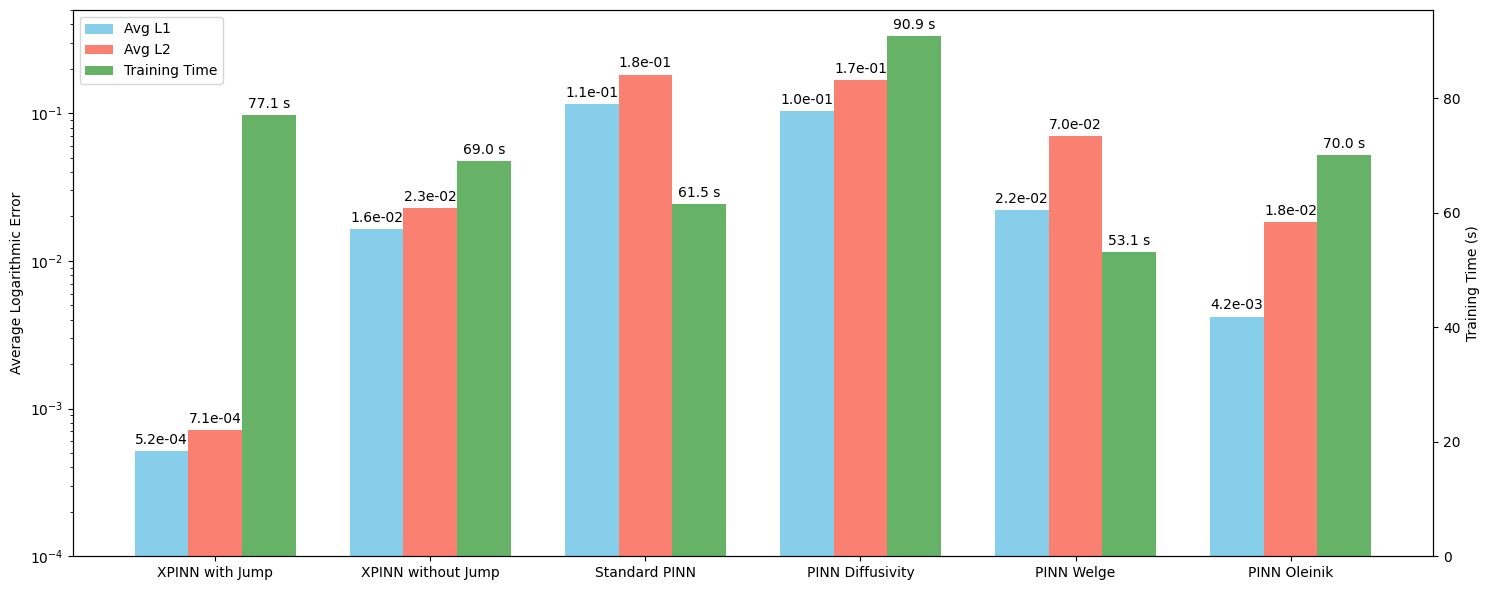

In [ ]:
methods = list(average_l1_errors.keys())
l1_vals = [average_l1_errors[m] for m in methods]
l2_vals = [average_l2_errors[m] for m in methods]

# Training times
training_times = [
    total_training_time_xpinn_jump,
    total_training_time_xpinn_no_jump,
    total_training_time_pinn,
    total_training_time_pinn_diffusivity,
    total_training_time_pinn_Welge,
    total_training_time_pinn_Oleinik
]


x = np.arange(len(methods)) * 2.0  # multiply to add extra gap between groups
width = 0.5  # increase bar width

fig, ax1 = plt.subplots(figsize=(15,6))

# Primary y-axis: L1 and L2 errors
bars1 = ax1.bar(x - width, l1_vals, width, label='Avg L1', color='skyblue')
bars2 = ax1.bar(x, l2_vals, width, label='Avg L2', color='salmon')

ax1.set_ylabel('Average Logarithmic Error')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=0, ha='center')
ax1.set_yscale('log')
ax1.set_ylim(1e-4, 5e-1)

# Annotate error bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.1e}',
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3),
                 textcoords='offset points',
                 ha='center', va='bottom')

# Secondary y-axis: training time
ax2 = ax1.twinx()
ax2.set_ylabel('Training Time (s)')

# Plot training times
bars3 = ax2.bar(x + width, training_times, width, label='Training Time', color='green', alpha=0.6)

# Annotate training time bars
for bar in bars3:
    height_val = bar.get_height()
    ax2.annotate(f'{height_val:.1f} s',
                 xy=(bar.get_x() + bar.get_width()/2, height_val),
                 xytext=(0, 3),
                 textcoords='offset points',
                 ha='center', va='bottom')


# Shared legends
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left')


plt.tight_layout()
plt.show()


### For $M = 30$, change $M$ to $30$ and `init_guess` to $0.2$ in a first and second cells, respectively, and run all code again.  